### Zadanie

Cel: Ekstrakcja twarzy osoby starszej (70+) z jednego zdjęcia i wklejenie twarzy gdzie indziej.

TODO:
- [x] Stworzyć repozytorium zawierające notebooka
- [x] Przeszukać internet w poszukiwaniu odpowiedniego modelu
- [x] Skompletowanie datasetu (15-30 zdjęć) - również przypadki skrajne, ale 1 osoba na zdjęciu max 15 stopni odchylenia od frontu
- [x] Anotacja danych
- [x] Przekształcenie w maski
- [x] Przetworzenie outputu z sieci binarną maskę
- [x] Implementacja metryki IoU
- [ ] Analiza działania na zdjęciach zawierających osoby starsze
- [ ] Zaproponowanie rozwiązania problemów powstałych na prezentowanym datasecie

### Analiza problemu


Modele:
- [Caffe model, only face](https://github.com/YuvalNirkin/face_segmentation) - caffe model
- [PyTorch, many elements](https://github.com/zllrunning/face-parsing.PyTorch) - no requirements specified (but latest version works! yay!)
- [Keras, many elements, many ported models](https://github.com/shaoanlu/face_toolbox_keras) - with specified requirements not working
- [PyTorch, many elements, part of GAN](https://github.com/switchablenorms/CelebAMask-HQ/tree/master/face_parsing) - pytorch 0.4.1 <3


Datasety:
- [CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ)
- [Helen](https://github.com/JPlin/Relabeled-HELEN-Dataset?utm_source=catalyzex.com)


Wybrano [PyTorch, many elements](https://github.com/zllrunning/face-parsing.PyTorch) ze względu na uniwersalność (co powinno być wykrywane ostatecznie jest kwestią biznesową)

In [ ]:
# imports
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from sklearn.metrics import jaccard_score

In [10]:
# Image pre-processing - resize all images to 512x512

path_to_dataset = "../my_dataset/"
output_dataset = "../output_dataset/"

for image_path in os.listdir(path_to_dataset):
    print(image_path)
    img = cv2.imread(os.path.join(path_to_dataset, image_path))
    img = cv2.resize(img, (512, 512))
    cv2.imwrite(os.path.join(output_dataset, image_path), img)

old_man_dark.jpg
very_old_man_02.jpeg
old_man.jpg
very_old_man_02.jpg
very_old_woman_no_color.jpg
old_woman_dark.jpg
old_man_in_mask.jpg
old_woman_with_mask.jpg
old_woman.jpg
old_asian_man.jpg
very_old_woman.jpg
strange_face_expression.jpg
old_black_man.jpg
very_old_woman_02.jpg
woman_glasses.jpg
old_man_mask.jpg
very_very_old_woman.jpg
very_old_man.jpg
indian_man.jpg
man_not_frontal.jpeg
old_man_02.jpg
old_man_03.jpg


Do labelowania danych posłuży narzędzie Labelbox. 

Założenie: Interesuje nas wykrywanie twarzy w całości. W związku z tym z wyłączeniem:
- włosów
- szyji
- uszów
- maseczki
- brody (za wyjątkiem tej, która zakrywa rysy twarzy)

Za to z włączeniem:
- Maski pokrywającej całą twarz
- Okularami


Dataset dołączono do repozytorium, aby było możliwe zapoznanie się z poszczególnymi krokami


In [11]:
# Get masks from .json file generated by labelbox

with open("../export-2021-06-10T14_31_06.887Z.json") as json_file:
    labels = json.load(json_file)
    for label in labels:
        filename = label["External ID"]
        mask_url = label["Label"]["objects"][0][
            "instanceURI"
        ]  # 0 - there is only one object (face) per image
        response = requests.get(mask_url)
        with open("../masks/" + filename, "wb") as file:
            file.write(response.content)
            file.close()

FileNotFoundError: [Errno 2] No such file or directory: '../masks/very_old_man_02.jpeg'

Pozostało ujednolicić wyjściowe obrazy z ground_truth oraz model_results

1 'skin', 2 'l_brow', 3 'r_brow', 4 'l_eye', 5 'r_eye', 6 'eye_g', 7 'l_ear', 8 'r_ear', 9 'ear_r',
10 'nose', 11 'mouth', 12 'u_lip', 13 'l_lip', 14 'neck', 15 'neck_l', 16 'cloth', 17 'hair', 18 'hat'

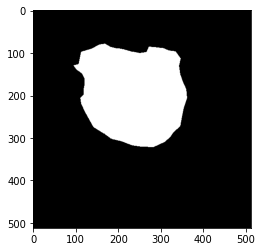

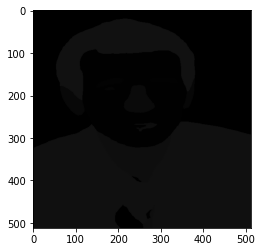

In [42]:
ground_truth = cv2.imread("../ground_truth/indian_man.jpg")
plt.imshow(ground_truth)
plt.show()

predicted = cv2.imread("../model_results/indian_man.png")
plt.imshow(predicted)
plt.show()

IoU dla jednego przypadku

In [43]:
predicted = cv2.imread("../model_results/indian_man.png")

print(np.unique(predicted))

[ 0  1  2  3  5  7  8 10 12 13 14 16 17]


In [72]:
# change mask to correct values


def process_predicted_data(img: np.ndarray) -> np.ndarray:
    """
    Convert predicted labels according to [0, 1] classes.

    :param img: input image
    :type img: np.ndarray
    :return: processed image
    :rtype: np.ndarray
    """
    img[img > 13] = 0
    img[img > 9] = 1
    img[img > 6] = 0
    img[img > 0] = 1
    return img


predicted = process_predicted_data(predicted)


def process_ground_truth_data(img: np.ndarray) -> np.ndarray:
    """
    Convert ground truth scale according to [0, 1] classes.

    :param img: input image
    :type img: np.ndarray
    :return: processed image
    :rtype: np.ndarray
    """
    img[img > 0] = 1
    return img


ground_truth = process_ground_truth_data(ground_truth)

In [45]:
iou = jaccard_score(ground_truth.flatten(), predicted.flatten())

In [46]:
print(iou)

0.9313522738680855


[0 1]


<Figure size 432x288 with 0 Axes>

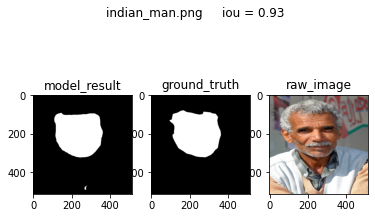

[0 1]


<Figure size 432x288 with 0 Axes>

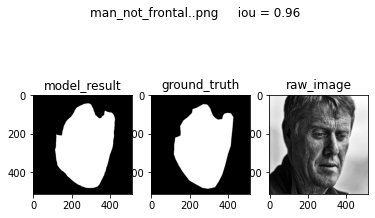

[0 1]


<Figure size 432x288 with 0 Axes>

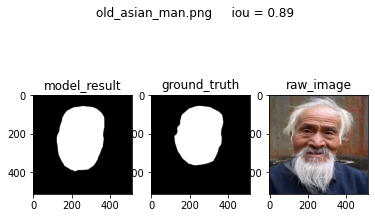

[0 1]


<Figure size 432x288 with 0 Axes>

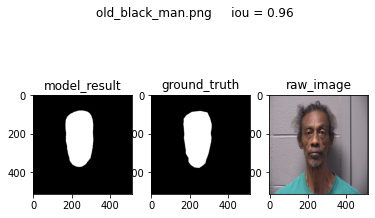

[0 1]


<Figure size 432x288 with 0 Axes>

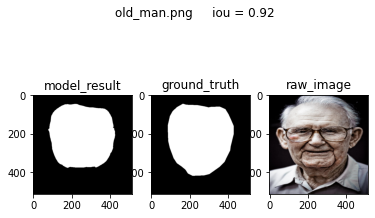

[0 1]


<Figure size 432x288 with 0 Axes>

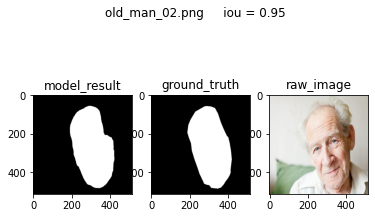

[0 1]


<Figure size 432x288 with 0 Axes>

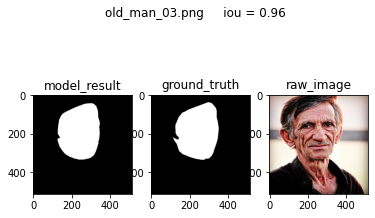

[0 1]


<Figure size 432x288 with 0 Axes>

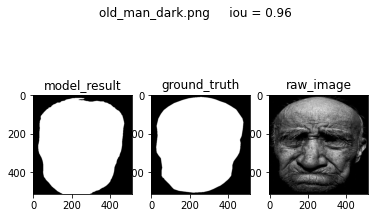

[0 1]


<Figure size 432x288 with 0 Axes>

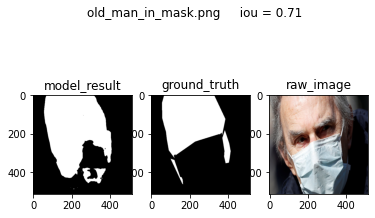

[0 1]


<Figure size 432x288 with 0 Axes>

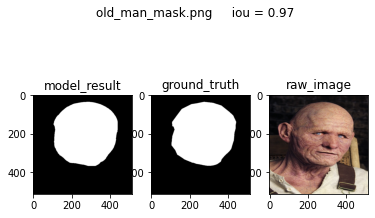

[0 1]


<Figure size 432x288 with 0 Axes>

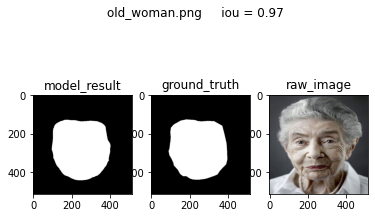

[0 1]


<Figure size 432x288 with 0 Axes>

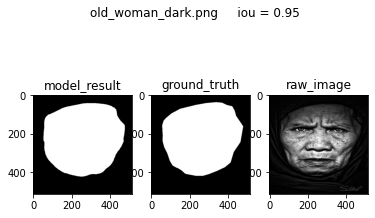

[0 1]


<Figure size 432x288 with 0 Axes>

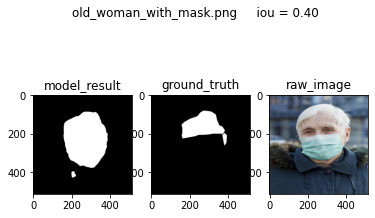

[0 1]


<Figure size 432x288 with 0 Axes>

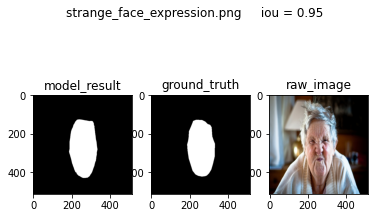

[0 1]


<Figure size 432x288 with 0 Axes>

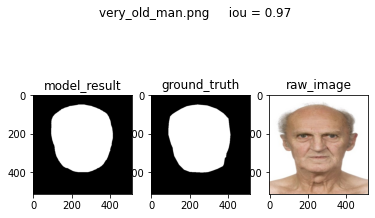

[0 1]


<Figure size 432x288 with 0 Axes>

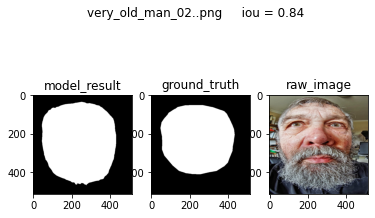

[0 1]


<Figure size 432x288 with 0 Axes>

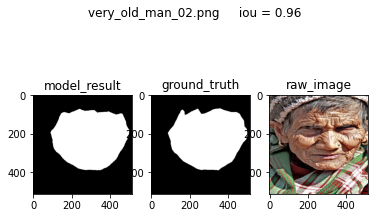

[0 1]


<Figure size 432x288 with 0 Axes>

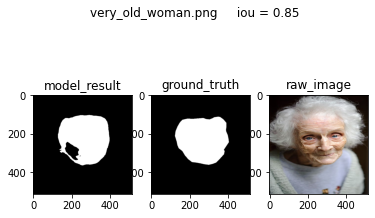

[0 1]


<Figure size 432x288 with 0 Axes>

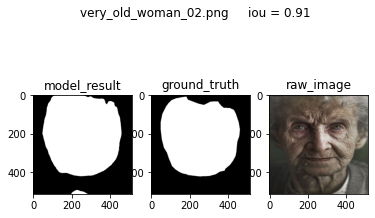

[0 1]


<Figure size 432x288 with 0 Axes>

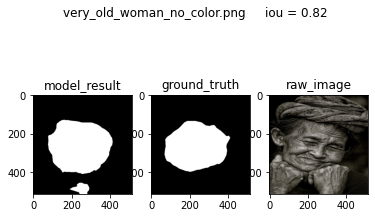

[0 1]


<Figure size 432x288 with 0 Axes>

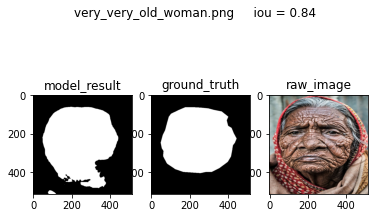

[0 1]


<Figure size 432x288 with 0 Axes>

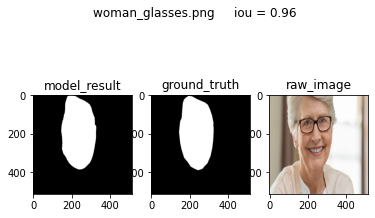

In [69]:
model_results_dict = "../model_results/"
ground_truth_dict = "../ground_truth/"
raw_images_dict = "../output_dataset/"

# Read imgs
model_result_imgs = [
    cv2.imread(os.path.join(model_results_dict, image_path))
    for image_path in sorted(os.listdir(model_results_dict))
]
ground_truth_imgs = [
    cv2.imread(os.path.join(ground_truth_dict, image_path))
    for image_path in sorted(os.listdir(ground_truth_dict))
]
raw_images_imgs = [
    cv2.imread(os.path.join(raw_images_dict, image_path))
    for image_path in sorted(os.listdir(raw_images_dict))
]

# bgr to rgb
raw_images_imgs = [cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB) for im_cv in raw_images_imgs]

# Prcoess imgs
model_result_imgs = [process_predicted_data(img) for img in model_result_imgs]
ground_truth_imgs = [process_ground_truth_data(img) for img in ground_truth_imgs]

ious = []
for result, ground_truth, image_name, raw_image in zip(
    model_result_imgs,
    ground_truth_imgs,
    sorted(os.listdir(model_results_dict)),
    raw_images_imgs,
):  # noqa: FKA01
    iou = jaccard_score(ground_truth.flatten(), result.flatten())
    ious.append(iou)

    plt.figure()
    print(np.unique(result))
    f, axarr = plt.subplots(1, 3)

    axarr[0].imshow(result * 255)
    axarr[1].imshow(ground_truth * 255)
    axarr[2].imshow(raw_image)

    axarr[0].title.set_text("model_result")
    axarr[1].title.set_text("ground_truth")
    axarr[2].title.set_text("raw_image")

    plt.suptitle(image_name + "     iou = " + "{:.2f}".format(iou))
    plt.show()

In [53]:
print(ious)

[0.9313522738680855, 0.9563449384916367, 0.8923015319817883, 0.9593740428257177, 0.9160865824566892, 0.9547720192580006, 0.9602632816173013, 0.9601469158005118, 0.7054648557186628, 0.9747517347638809, 0.9682292321226593, 0.9503898658118268, 0.3966940573106328, 0.9460572662197477, 0.9716758288953788, 0.8364255963650132, 0.9600103353010156, 0.8549714126342212, 0.9134380357622369, 0.8229229758115439, 0.8361924037410025, 0.9610814941503976]


In [55]:
mean_iou = sum(ious) / len(ious)
print(mean_iou)

0.8922248491321798
